This experiment evaluates the evolution of the error as the number of graphs to be inferred increases. It compares the performance of independently identifying K similar graphs with respect the performance of a joint inference algorithm. 

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

import time
from joblib import Parallel, delayed
from os import cpu_count

import utils
import opt

SEED = 0
PATH = 'results/joint_inf/'
N_CPUS = cpu_count()
np.random.seed(SEED)

### Auxiliary functions

In [4]:
#GL     --> rho1 = 0.1
#GGL    --> rho1 = 0.01, rho2 = 0.01
#LVGL   --> rho1 = 0.0316, beta1 = 1
#Joint  --> rho1 = 0.01, rho2 =0.01, beta1 = 0.1, beta2 = 0.1

#GL     --> rho1 = 0.1
#GGL    --> rho1 = 0.1, rho2 = 0.01
#LVGL   --> rho1 = 0.0316, beta1 = 1
#Joint  --> rho1 = 0.0316, rho2 =0.01, beta1 = 1, beta2 = 0.1

#GL     --> rho1 = 0.1
#GGL    --> rho1 = 0.07, rho2 = 0.03
#LVGL   --> rho1 = 0.07, beta1 = 0.7
#Joint  --> rho1 = 0.05, rho2 =0.02, beta1 = 0.3, beta2 = 0.2


def plot_err(KK, err, ylab, logy=True, ylim=[]):
    plt.figure()
    if logy:
        plt.semilogy(KK, err[:,0], 'o:', linewidth=2, markersize=12, label='GL')
        plt.semilogy(KK, err[:,1], 'o-.', linewidth=2, markersize=12, label='GGL')
        plt.semilogy(KK, err[:,2], 'o-', linewidth=2, markersize=12, label='LVGL')
        plt.semilogy(KK, err[:,3], 'o--', linewidth=2, markersize=12, label='Joint Hidden')
    else:
        plt.plot(KK, err[:,0], 'o:', linewidth=2, markersize=12, label='GL')
        plt.plot(KK, err[:,1], 'o-.', linewidth=2, markersize=12, label='GGL')
        plt.plot(KK, err[:,2], 'o-', linewidth=2, markersize=12, label='LVGL')
        plt.plot(KK, err[:,3], 'o--', linewidth=2, markersize=12, label='Joint Hidden')

    plt.grid(True)
    plt.xlabel('Number of graphs')
    plt.ylabel(ylab)
    plt.legend()
    plt.xlim([KK[0], KK[-1]])
    if ylim:
        plt.ylim(ylim)
    plt.tight_layout()


def run_exp(id, KK, N, O, p, M, pert_links, regs):
    # Create graphs
    A = np.zeros((N,N))
    tries = 0
    while np.any(np.sum(A,axis=1) == 0) and tries < 100:
        tries += 1
        A = nx.to_numpy_array(nx.erdos_renyi_graph(N, p))
        #A = nx.to_numpy_array(nx.connected_watts_strogatz_graph(N,k,p))

    assert not np.any(np.sum(A,axis=1) == 0), 'Graphs with nodes with degree 0'

    As = utils.gen_similar_graphs(A, KK[-1], pert_links)
    
    # Fix scale
    As = As/np.sum(As[0,1:,0])

    _, Cs_hat = utils.create_GMRF_data(As, M)

    # Randomly select observed/hidden nodes
    rand_idx = np.random.permutation(np.arange(N))
    idx_o = rand_idx[:O]
    
    Aos = As[:,idx_o,:][:,:,idx_o]
    Cos_hat = Cs_hat[:,idx_o,:][:,:,idx_o]

    diag_idx = np.eye(O, dtype=bool)
    err_mean_norm = np.zeros((len(KK), 4))
    err_unit_norm = np.zeros((len(KK), 4))
    for i, K in enumerate(KK):
        Cok_hat = Cos_hat[:K,:,:]
        
        S_ggl = opt.GGL(Cok_hat, regs)
        S_joint, _ = opt.joint_inf_Apsd(Cok_hat, regs)

        norm_Ao_sq = 0
        S_lvgl = np.zeros(Cok_hat.shape)
        S_sep_noh = np.zeros(Cok_hat.shape)
        errs_aux = np.zeros(4)
        errs_unit = np.zeros(4)
        for k in range(K):
            norm_Aok = np.linalg.norm(Aos[k,:,:], 'fro')
            norm_Ao_sq += norm_Aok**2

            S_sep_noh[k,:,:] =  opt.GL(Cok_hat[k,:,:], regs)
            S_lvgl[k,:,:], _ = opt.LVGL(Cok_hat[k,:,:], regs)

            # Set diags to 0
            S_sep_noh[k,:,:][diag_idx] = 0
            S_ggl[k,:,:][diag_idx] = 0
            S_lvgl[k,:,:][diag_idx] = 0
            S_joint[k,:,:][diag_idx] = 0
            
            # Errs
            errs_aux[0] = np.linalg.norm(S_sep_noh[k,:,:] - Aos[k,:,:], 'fro')**2
            errs_aux[1] = np.linalg.norm(S_ggl[k,:,:] - Aos[k,:,:], 'fro')**2
            errs_aux[2] = np.linalg.norm(S_lvgl[k,:,:] - Aos[k,:,:], 'fro')**2
            errs_aux[3] = np.linalg.norm(S_joint[k,:,:] - Aos[k,:,:], 'fro')**2
            
            errs_unit[0] = np.linalg.norm(S_sep_noh[k,:,:]/np.linalg.norm(S_sep_noh[k,:,:], 'fro') - Aos[k,:,:]/norm_Aok, 'fro')**2
            errs_unit[1] = np.linalg.norm(S_ggl[k,:,:]/np.linalg.norm(S_ggl[k,:,:], 'fro') - Aos[k,:,:]/norm_Aok, 'fro')**2
            errs_unit[2] = np.linalg.norm(S_lvgl[k,:,:]/np.linalg.norm(S_lvgl[k,:,:], 'fro') - Aos[k,:,:]/norm_Aok, 'fro')**2
            errs_unit[3] = np.linalg.norm(S_joint[k,:,:]/np.linalg.norm(S_joint[k,:,:], 'fro') - Aos[k,:,:]/norm_Aok, 'fro')**2

            # Compute errors
            err_mean_norm[i,:] += errs_aux/norm_Aok**2/K
            err_unit_norm[i,:] += errs_unit/K

        print('{}-{}: Err LVGL: {:.4f} - Err joint: {:.4f}'.format(id, K, err_mean_norm[i,2], err_mean_norm[i,3]))

    return err_mean_norm, err_unit_norm

In [5]:
# Experiment parameters
#KK = [1, 2, 3, 4,5,6]
KK = [1, 2, 3, 4,5,6]
N = 20
O = 19
p = .15
M = 200
pert_links = 5
n_graphs = 100
#regs = {'rho1': .0316, 'rho2': 0.01, 'beta1': 1, 'beta2': 0.1}
regs = {'rho1': .05, 'rho2': 0.02, 'beta1': 0.3, 'beta2': 0.2}
#Joint  --> rho1 = 0.0316, rho2 =0.01, beta1 = 1, beta2 = 0.1

err_mean_norm = np.zeros((len(KK), 4, n_graphs))
err_unit_norm = np.zeros((len(KK), 4, n_graphs))

total_t = time.time()
print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(run_exp)(i, KK, N, O, p, M, pert_links, regs) for i in range(n_graphs))
for i, resp in enumerate(resps):
        err_mean_norm[:,:,i], err_unit_norm[:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')


N_CPUS: 64
16-1: Err LVGL: 0.2118 - Err joint: 0.1476
13-1: Err LVGL: 0.1966 - Err joint: 0.1372
19-1: Err LVGL: 0.3101 - Err joint: 0.2331
0-1: Err LVGL: 0.1291 - Err joint: 0.0758
14-1: Err LVGL: 0.3779 - Err joint: 0.2528
12-1: Err LVGL: 0.2088 - Err joint: 0.1332
28-1: Err LVGL: 0.3641 - Err joint: 0.2847
38-1: Err LVGL: 0.2972 - Err joint: 0.1617
21-1: Err LVGL: 0.1473 - Err joint: 0.1198
31-1: Err LVGL: 0.2223 - Err joint: 0.1363
7-1: Err LVGL: 0.1276 - Err joint: 0.1599
6-1: Err LVGL: 0.3811 - Err joint: 0.3166
10-1: Err LVGL: 0.2162 - Err joint: 0.1087
30-1: Err LVGL: 0.2445 - Err joint: 0.1736
43-1: Err LVGL: 0.3266 - Err joint: 0.2578
48-1: Err LVGL: 0.2828 - Err joint: 0.2156
3-1: Err LVGL: 0.1895 - Err joint: 0.1346
42-1: Err LVGL: 0.1889 - Err joint: 0.1130
17-1: Err LVGL: 0.2054 - Err joint: 0.1273
23-1: Err LVGL: 0.0678 - Err joint: 0.0944
4-1: Err LVGL: 0.1139 - Err joint: 0.0959
51-1: Err LVGL: 0.3149 - Err joint: 0.2845
22-1: Err LVGL: 0.1265 - Err joint: 0.1527
15-1:

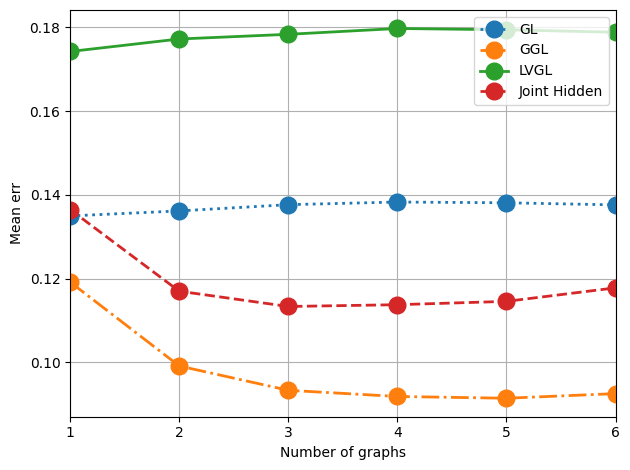

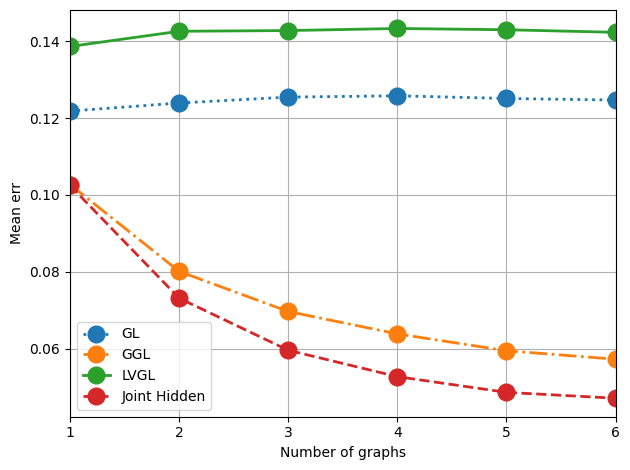

In [6]:
# %matplotlib qt
err_mean_norm_mean = np.mean(err_mean_norm, axis=2)
err_mean_unit_norm = np.mean(err_unit_norm, axis=2)

plot_err(KK, err_mean_norm_mean, 'Mean err', logy=False)
plot_err(KK, err_mean_unit_norm, 'Mean err', logy=False)

In [67]:
err_mean_norm_mean = np.mean(err_mean_norm, axis=2)
err_mean_unit_norm = np.mean(err_unit_norm, axis=2)

#plot_err(KK, err_mean, 'Mean err', logy=True)
#plot_err(KK, err_mean_norm_mean, 'Mean err', logy=True)
#plot_err(KK, err_mean_unit_norm, 'Mean err', logy=True)

[[ 4.47278934  3.59602659 20.55274677  3.43481373]
 [37.10480556 36.35113787 41.10549048 39.88210071]
 [56.39967365 55.80358646 61.63325166 60.40999475]
 [74.4072339  73.98233666 82.03600092 80.80917756]]
[[0.20480699 0.17769112 0.99999747 0.16280046]
 [0.81268187 0.79912937 0.99999771 0.96532252]
 [0.80841094 0.8054723  0.9999983  0.97691206]
 [0.82523293 0.82830581 0.99999827 0.98261454]]
[[0.20396981 0.17025748 1.67507196 0.1579953 ]
 [0.88950307 0.84403336 1.77033353 1.80951965]
 [0.90329038 0.8715612  1.83405406 1.85404517]
 [0.92186991 0.90199229 1.84682392 1.76222387]]


In [175]:
data = {
    'err_mean_norm_mean':err_mean_norm_mean,
    # 'err_mean_norm_mean1': err_mean_unit_norm,
    'err_mean_unit_norm': err_mean_unit_norm,
    'KK': KK
}
np.save('exp_k5_v1',data)

In [185]:
def error_to_csv(fname, models, xaxis, error):
    header = ''
    data = error
    
    if xaxis is not None:
        data = np.concatenate((xaxis.reshape([xaxis.size, 1]), error.T), axis=1)
        header = 'xaxis, '  

    for i, model in enumerate(models):
        header += model
        if i < len(models)-1:
            header += ', '

    np.savetxt(fname, data, delimiter=',', header=header, comments='')
    print('SAVED as:', fname)

In [199]:
# error_to_csv('data_v2',['GL','GGL','LVGL','Joint'],np.array(KK),aux2.T)

SAVED as: data_v2


In [192]:
# aux1 = np.load('exp_k5.npy',allow_pickle=True)

In [198]:
# aux2 = aux1.item()['err_mean_norm_mean']